In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import traclus as tr
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import cv2
import random as rand

# plt.rcParams['figure.figsize'] = (12, 12)
# sns.set()

Actual Output:
[[ 2.   0.8]
 [-0.5  0.5]
 [ 1.   0.2]
 [ 2.   0.2]]


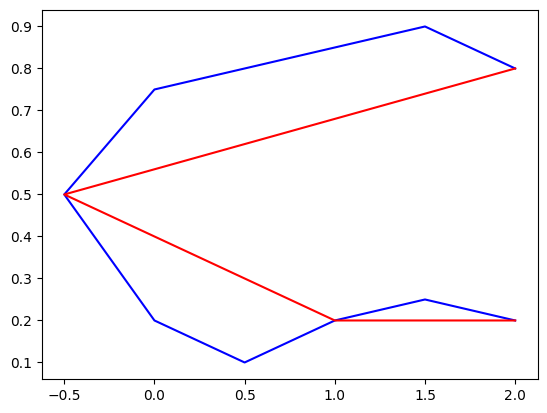

In [3]:
test_line = np.array([[2, 0.8], [1.5, 0.9], [0, 0.75], [-0.5, 0.5], [0, 0.2], [0.5, 0.1], [1, 0.2], [1.5, 0.25], [2, 0.2]])
partitions = tr.partition(test_line)

print("Actual Output:")
print(partitions)

# Plot the test line
plt.plot(test_line[:,0], test_line[:,1], 'b')

# Plot the partitions as a line
plt.plot(partitions[:,0], partitions[:,1], 'r')

In [4]:
vehicle_detections = None
with open("yt.vts", "rb") as f:
    vehicle_detections = pickle.load(f)

In [5]:
# Get the center of the bounding box
for i in range(len(vehicle_detections)):
    vehicle_detections[i]["centroids"] = np.array([[(x[0] + x[2]) / 2, (x[1] + x[3]) / 2] for x in vehicle_detections[i]["centroids"]])

In [33]:
all_trajectories = []
for i in range(len(vehicle_detections)):
    all_trajectories.append(tr.sub_sample_trajectory(vehicle_detections[i]["centroids"], sample_n=10))

In [10]:
# Grab a random from the video
cap = cv2.VideoCapture("youtube_test_1.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, rand.randint(0, 2000))
ret, frame = cap.read()
cap.release()

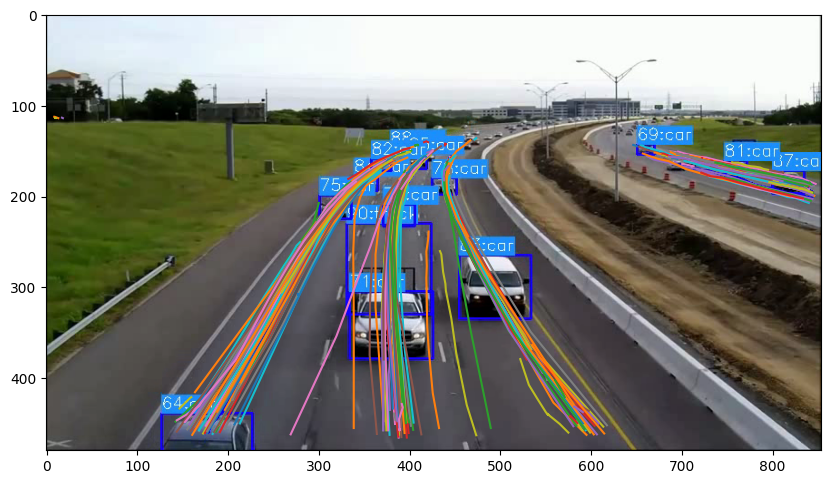

In [34]:
# Visualize
plt.figure(figsize=(10,10))
for i in range(len(all_trajectories)):
    plt.plot(all_trajectories[i][:,0] * frame.shape[1], all_trajectories[i][:,1] * frame.shape[0])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [12]:
all_trajectories[0]

array([[0.4432085, 0.509375 ],
       [0.4408665, 0.530208 ],
       [0.4408665, 0.5510415],
       [0.4408665, 0.575    ],
       [0.4408665, 0.6166665],
       [0.4420375, 0.671875 ],
       [0.4449645, 0.744792 ],
       [0.4455505, 0.8125   ],
       [0.448478 , 0.89375  ],
       [0.4531615, 0.94375  ]])

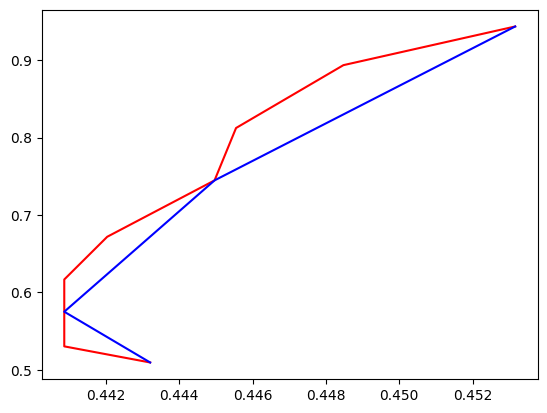

In [13]:
traj = all_trajectories[0]
plt.plot(traj[:,0], traj[:,1], 'r')

# Get the partitions of this trajectory
partitions = tr.partition(traj)

# Plot the partitions as a line
plt.plot(partitions[:,0], partitions[:,1], 'b')

In [36]:
n_traj = len(all_trajectories)
trajectory_partitions = []
for i in range(n_traj):
    print(f"Partitioning trajectory {i+1}/{n_traj}", end='\r')
    trajectory_partitions.append( tr.partition(all_trajectories[i], progress_bar=True) )

90.0%Partitioning trajectory 259/259

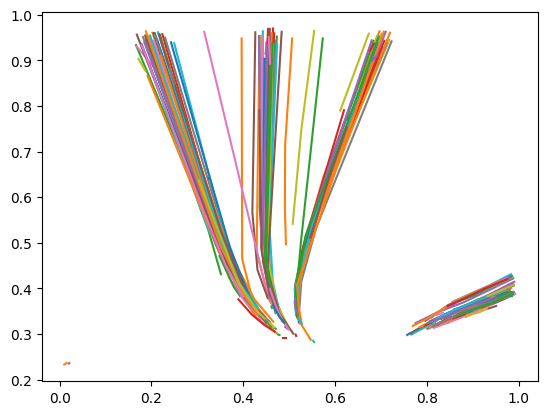

In [37]:
for traj_part in trajectory_partitions:
    plt.plot(traj_part[:,0], traj_part[:,1])

In [19]:
trajectory_partitions[0]

array([[0.4432085, 0.509375 ],
       [0.4408665, 0.575    ],
       [0.4449645, 0.744792 ],
       [0.4531615, 0.94375  ]])

In [38]:
# Create Distance Matrix between all trajectories
n_partitions = len(trajectory_partitions)
dist_matrix = np.zeros((n_partitions, n_partitions))
for i in range(n_traj):
    for j in range(i+1):
        dist_matrix[i,j] = tr.distance(trajectory_partitions[i], trajectory_partitions[j])
        print(f'Progress: {i+1}/{n_traj}', end='\r')

In [39]:
# Fill in the upper triangle
dist_matrix = dist_matrix + dist_matrix.T - np.diag(dist_matrix.diagonal())

In [19]:
with open("yt_dist_matrix_partitions_3.vts", "wb") as f:
    pickle.dump([trajectory_partitions, dist_matrix], f)

with open("backup_dist_matrix.npy", "wb") as f:
    np.save(f, dist_matrix)

In [5]:
dist_matrix = trajectory_partitions = None
with open("yt_dist_matrix_partitions.vts", "rb") as f:
    l = pickle.load(f)
    trajectory_partitions = l[0]
    dist_matrix = l[1]

In [22]:
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst, img=None, filter_outliers=False):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''

    normalization_factor_x = normalization_factor_y = 1
    if img is not None:
        plt.imshow(img)
        normalization_factor_x = img.shape[1]
        normalization_factor_y = img.shape[0]
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            if not filter_outliers: plt.plot((traj[:, 0] * normalization_factor_x), traj[:, 1] * normalization_factor_y, c='k', linestyle='dashed')
        
        else:
            plt.plot((traj[:, 0] * normalization_factor_x), traj[:, 1] * normalization_factor_y, c=color_lst[cluster % len(color_lst)])
    plt.show()

In [40]:
np.isnan(dist_matrix).sum()

0

In [23]:
# Find the nan values in the distance matrix and replace them with np.inf
nan_indices = np.argwhere(np.isnan(dist_matrix))
for i, j in nan_indices:
    dist_matrix[i,j] = 99999999

In [24]:
# Grab a single frame from the video
cap = cv2.VideoCapture("youtube_test_1.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)
ret, frame = cap.read()
cap.release()

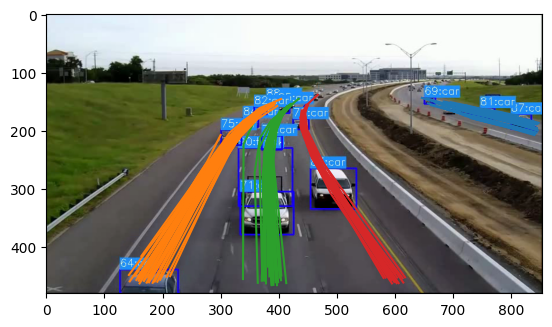

In [43]:
model = DBSCAN(eps=1, min_samples=10)
cluster_list = model.fit_predict(dist_matrix)

plot_cluster(trajectory_partitions, cluster_list, filter_outliers=True, img=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [44]:
np.min(cluster_list), np.max(cluster_list)

(-1, 4)

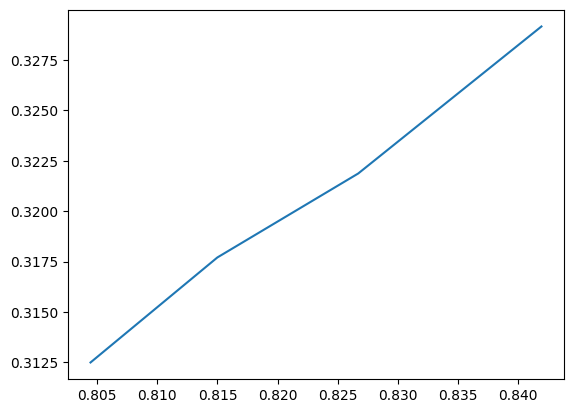

In [45]:
# Plot a random line in trajectory partitions
rand_traj = rand.randint(0, len(trajectory_partitions))
plt.plot(trajectory_partitions[rand_traj][:,0], trajectory_partitions[rand_traj][:,1])

[Intuition for Lane Mask Generation]

1. Generate representative trajectory for each identified lane cluster.
2. Aggregate bounding box edges L and R (left bound & right bound)
3. Perform curve fitting for the representative trajectory of each identified lane cluster
4. Perform curve fitting for L and R edges in the bounding boxes
5. Get pixel segmentation area using integrals

[Another Intuition for Lane Mask Generation]
1. Generate representative trajectories for each identified lane cluster.
2. Find midpoint between representative trajectories, treat them as lane boundaries.

Present 2 types of segmentation:
1. Lane mask (membership)
2. Heatmap (density)

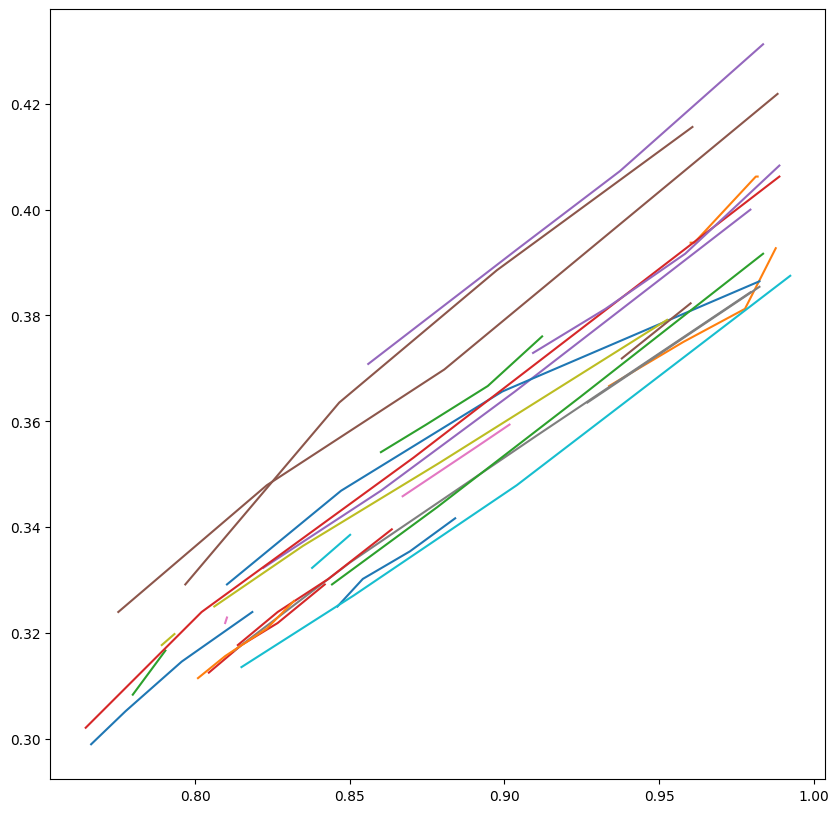

In [31]:
# Test the vector average algorithm
# Get all lines from cluster 2
cluster_indices = np.argwhere(cluster_list == 2).flatten()
mock_lines = [trajectory_partitions[i] for i in cluster_indices]
# Plot the mock lines
plt.figure(figsize=(10,10))
for line in mock_lines:
    plt.plot(line[:,0], line[:,1])


In [32]:
test = tr.get_representative_trajectory(mock_lines)

# Plot test
plt.figure(figsize=(10,10))
for line in test:
    plt.plot(line[:,0], line[:,1])

/Users/adrielamoguis/THESIS/RLSFD/trajectory-based/traclus.py:508: UserWarning: WARNING: No representative points were found.
  warnings.warn("WARNING: No representative points were found.")


<Figure size 1000x1000 with 0 Axes>

/Users/adrielamoguis/THESIS/RLSFD/trajectory-based/traclus.py:442: UserWarning: WARNING: No representative points were found.
  Trajectory Clustering Algorithm


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

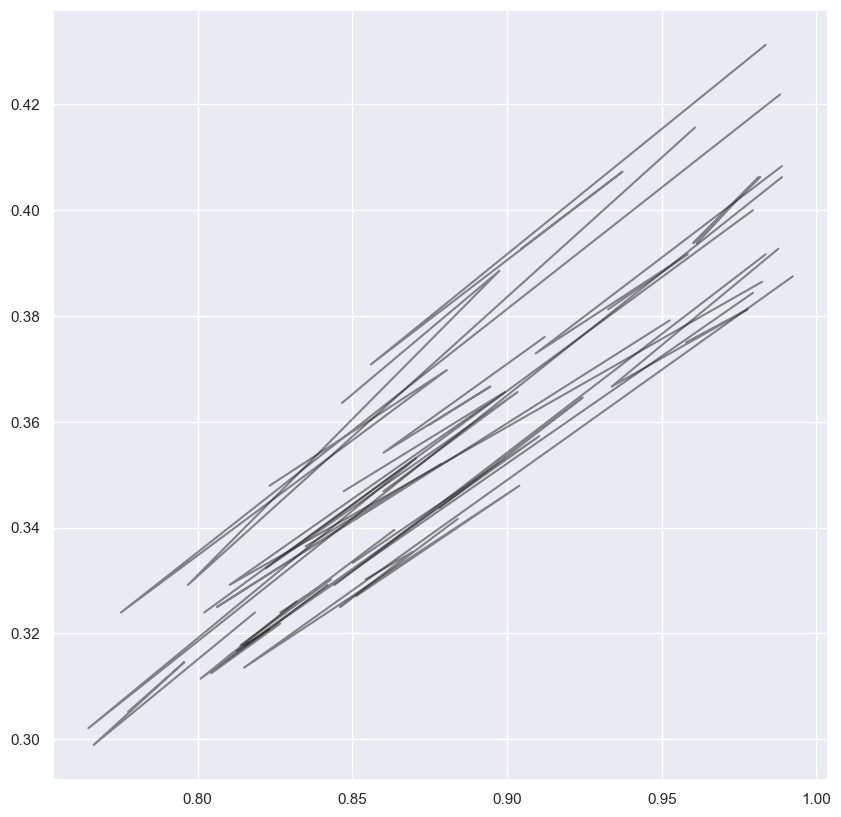

In [167]:
representative_trajectory = tr.get_representative_trajectory(mock_lines, min_lines=1)

# Plot the representative trajectory against the mock lines
plt.figure(figsize=(10,10))
for line in mock_lines:
    plt.plot(line[:,0], line[:,1], c='k', alpha=0.5)
plt.plot(representative_trajectory[:,0], representative_trajectory[:,1], c='r')

#### Testing out the Representative Trajectory Generation

In [91]:
# Find the representative trajectory for every cluster
representative_trajectories = []
for cluster in range(np.max(cluster_list)):
    cluster_indices = np.argwhere(cluster_list == cluster).flatten()
    lines = [trajectory_partitions[i] for i in cluster_indices]
    print(tr.get_representative_trajectory(lines))
    representative_trajectories.append(tr.get_representative_trajectory(lines))

[]
[]
[]


/Users/adrielamoguis/THESIS/RLSFD/trajectory-based/traclus.py:329: UserWarning: WARNING: No representative points were found.
  warnings.warn("WARNING: No representative points were found.")


In [89]:
representative_trajectories

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

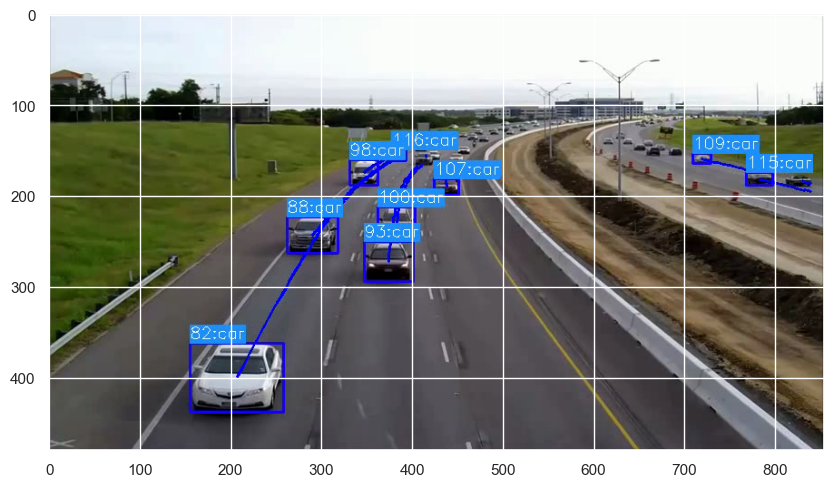

In [81]:
# Plot the representative trajectories against the image
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
for traj in representative_trajectories:
    plt.plot(traj[:,0], traj[:,1], c='r')

In [50]:
# Test the whole pipeline
cap = cv2.VideoCapture("youtube_test_1.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)
ret, frame = cap.read()
cap.release()

results = tr.traclus(all_trajectories, progress_bar=True)

Partitioning trajectories...
90.0%


/Users/adrielamoguis/THESIS/RLSFD/trajectory-based/traclus.py:271: RuntimeWarning: divide by zero encountered in log2
  LH += np.log2(d_euclidean(trajectory[i], trajectory[i+1]))


Grouping partitions...

Getting representative trajectories...
[[0.492974  0.496875 ]
 [0.490632  0.5760415]
 [0.491218  0.715625 ]
 [0.5064405 0.9479165]
 [0.611241  0.7895835]
 [0.673302  0.958333 ]
 [0.8103045 0.322917 ]
 [0.809719  0.321875 ]
 [0.411007  0.3895835]
 [0.4039815 0.4020835]
 [0.7985945 0.317708 ]
 [0.7985945 0.317708 ]
 [0.4906325 0.325    ]
 [0.485363  0.33125  ]
 [0.4473065 0.3302085]
 [0.442623  0.3322915]
 [0.51815   0.359375 ]
 [0.5175645 0.359375 ]
 [0.4625295 0.3572915]
 [0.4613585 0.3604165]
 [0.483021  0.3416665]
 [0.4777515 0.3427085]
 [0.4800935 0.3333335]
 [0.479508  0.3333335]
 [0.5210775 0.325    ]
 [0.520492  0.3270835]
 [0.5187355 0.3322915]
 [0.5128805 0.359375 ]
 [0.51815   0.4125   ]
 [0.5632315 0.5760415]
 [0.5222485 0.326042 ]
 [0.513466  0.3729165]
 [0.529274  0.486458 ]
 [0.619438  0.790625 ]
 [0.525761  0.44375  ]
 [0.54274   0.5083335]
 [0.5860655 0.647917 ]
 [0.6697895 0.8770835]
 [0.487705  0.3260415]
 [0.484192  0.33125  ]
 [0.480679  0.336

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed